# Deforestation Data Processing- Toby Liang

## Importing Essential Libraries

In [14]:
# Importing matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Importing numpy, sparse matrix, pandas, and rasterio
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
import rasterio as rio

## Loading Deforestation Data

In [17]:
# Loading deforestation data
defor_img_path = "../data/raw/10S60W.tif"
with rio.open(defor_img_path) as src:
    defor_data = src.read()
defor_data = np.squeeze(defor_data)

In [18]:
# Create defor_array
defor_array = np.array(defor_data)
defor_array.shape

(40000, 40000)

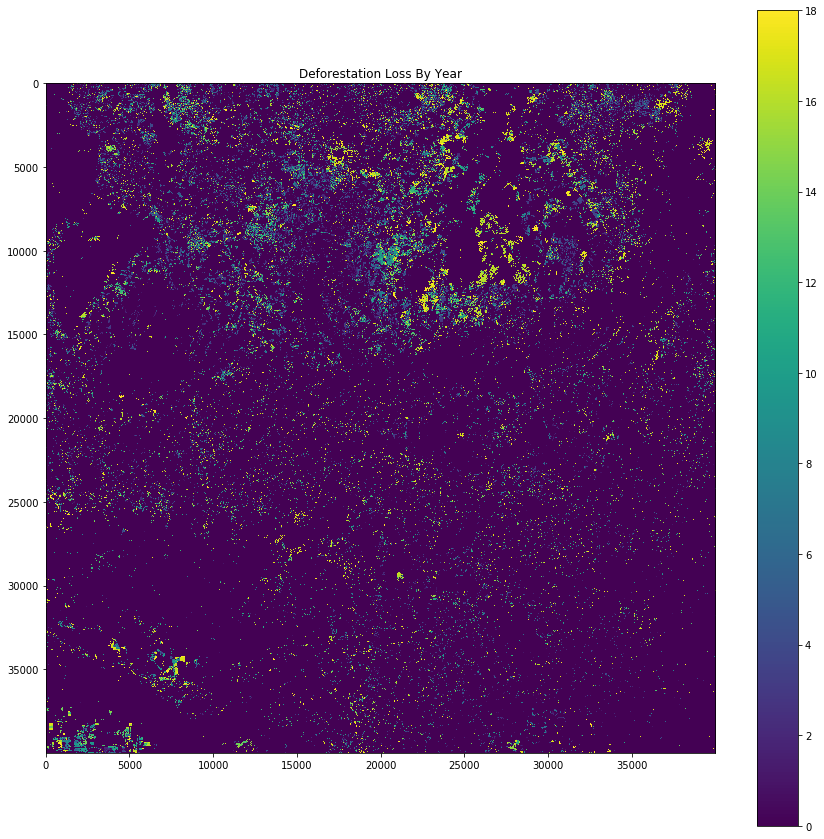

In [4]:
# Plot deforestation data
plt.figure(figsize = (15, 15))
plt.title("Deforestation Loss By Year")
plt.imshow(defor_array)
plt.colorbar()
plt.show()

## Splitting Years

In [5]:
'''
Takes the deforestation array and outputs a dictionary with years (from 2001) as keys and deforestation data per year
as a csr sparse matrix as values.
'''
def split_years(defor_array, verbose = True):
    output_dict = dict()
    for year in np.unique(defor_array):
        # Ignore 0s (indicates no deforestation not year)
        if year == 0:
            continue
            
        # Print status
        if verbose:
            print("Splitting year {}".format(2000 + year))
            
        # Split years
        output_dict["{}".format(2000 + year)] = csr_matrix((defor_array == year).astype(int))
        
    return output_dict

In [6]:
defor_array_year_dict = split_years(defor_array)

Splitting year 2001
Splitting year 2002
Splitting year 2003
Splitting year 2004
Splitting year 2005
Splitting year 2006
Splitting year 2007
Splitting year 2008
Splitting year 2009
Splitting year 2010
Splitting year 2011
Splitting year 2012
Splitting year 2013
Splitting year 2014
Splitting year 2015
Splitting year 2016
Splitting year 2017
Splitting year 2018


## Generate Resizable Grid

In [7]:
PIXEL_NUM_METERS = 30 # number of meters per side of pixel

In [8]:
'''
Rounds input x to the nearest multiple of input base.
'''
def round_base(x, base = PIXEL_NUM_METERS):
    return base * round(x / base)

'''
Generates a grid where each cell represents the sum of a cell_num_meter by cell_num_meter chunk of data.
Returns a tuple of sum grid, cell_num_meter.
'''
def data_to_grid(defor_array, cell_num_meter = 3000, verbose = True):
    # Round cell_num_meter to be a multiple of PIXEL_NUM_METER
    if cell_num_meter % PIXEL_NUM_METERS != 0:
        rounded = round_base(cell_num_meter)
        cell_num_meter = rounded # number of meters per side of grid cell
        # Print warning
        if verbose:
            print("Warning: invalid size of {} meters rounded to {} meters".format(cell_num_meter, rounded))

    # Initialize constants
    PIXELS_PER_CELL = cell_num_meter // PIXEL_NUM_METERS # number of pixels in one grid cell 
    GRID_SIZE = defor_array.shape[0] // PIXELS_PER_CELL # number of grid cells in side of grid
    
    # Initialize grids
    sum_grid = np.zeros((GRID_SIZE, GRID_SIZE))
    
    # Generate grids
    for y in range(0, defor_array.shape[0], PIXELS_PER_CELL):
        for x in range(0, defor_array.shape[1], PIXELS_PER_CELL):
            sum_grid[y // PIXELS_PER_CELL, x // PIXELS_PER_CELL] = np.sum(defor_array[y:y+PIXELS_PER_CELL, x:x+PIXELS_PER_CELL])
    
    # Print grid shapes
    if verbose:
        print("Generated sum grid of shape {} at index 0".format(sum_grid.shape))
        print("Returned cell_num_meter at index 1\n")
    
    return (sum_grid, cell_num_meter)

In [9]:
sum_grid_dict = dict()
for year, sparse_year_data in defor_array_year_dict.items():
    print("Sum grid year {}".format(int(year)))
    sum_grid_dict[str((int(year)))] = data_to_grid(sparse_year_data.todense(), 3001)[0]

Sum grid year 2001
Generated sum grid of shape (400, 400) at index 0
Returned cell_num_meter at index 1

Sum grid year 2002
Generated sum grid of shape (400, 400) at index 0
Returned cell_num_meter at index 1

Sum grid year 2003
Generated sum grid of shape (400, 400) at index 0
Returned cell_num_meter at index 1

Sum grid year 2004
Generated sum grid of shape (400, 400) at index 0
Returned cell_num_meter at index 1

Sum grid year 2005
Generated sum grid of shape (400, 400) at index 0
Returned cell_num_meter at index 1

Sum grid year 2006
Generated sum grid of shape (400, 400) at index 0
Returned cell_num_meter at index 1

Sum grid year 2007
Generated sum grid of shape (400, 400) at index 0
Returned cell_num_meter at index 1

Sum grid year 2008
Generated sum grid of shape (400, 400) at index 0
Returned cell_num_meter at index 1

Sum grid year 2009
Generated sum grid of shape (400, 400) at index 0
Returned cell_num_meter at index 1

Sum grid year 2010
Generated sum grid of shape (400, 40

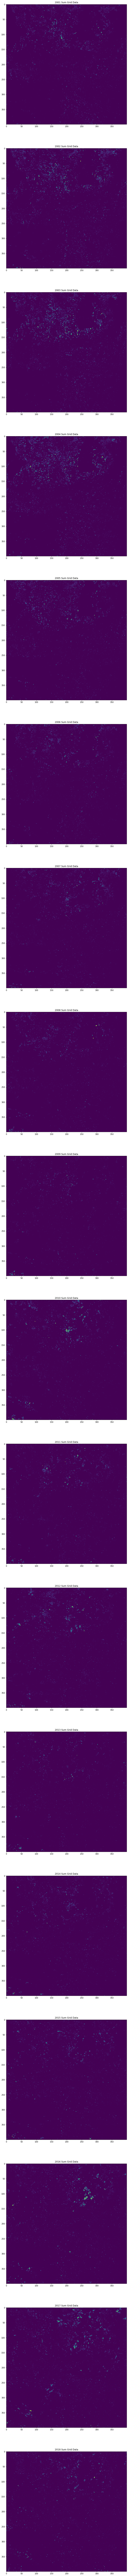

In [10]:
fig, ax = plt.subplots(nrows = 18, ncols = 1, figsize = (20, 250))
index = 0
for year, grid_data in sum_grid_dict.items():
    ax[index].imshow(grid_data)
    ax[index].set_title("{} Sum Grid Data".format(year))
    index += 1

plt.show()

## Creating DataFrame and Saving to CSV

In [11]:
for year, grid_data in sum_grid_dict.items():
    # Compute rows and cols
    row = np.arange(grid_data.size) // grid_data.shape[0]
    col = np.arange(grid_data.size) % grid_data.shape[1]
    
    # Generate dataframe
    df_dict = {"id": row * grid_data.shape[1] + col, "year": year, "value": grid_data.flatten(), "row": row, "col": col}
    df = pd.DataFrame(data = df_dict)
    
    # Save to csv file
    df.to_csv("../data/processed/defor_{}.csv".format(year), index = False)